# Detecção de Anomalias - Water Quality

### Discentes: Angelo, Aquila e Luis Otávio

### Algoritmos Implementados:
1. **Isolation Forest** - Baseado em isolamento de observações
2. **Local Outlier Factor (LOF)** - Baseado em densidade local
3. **Autoencoder** - Rede neural para reconstrução

### Objetivo:
Detectar amostras de água com características anômalas que possam indicar problemas de qualidade ou contaminação.

## Importação das Bibliotecas Necessárias

In [64]:
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

# from google.colab import drive
# drive.mount('/content/drive')

import matplotlib.pyplot as plt
import seaborn as sns

try:
    plt.style.use('seaborn-v0_8-whitegrid')
except:
    try:
        plt.style.use('seaborn-whitegrid')
    except:
        plt.style.use('ggplot')

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, silhouette_score
from sklearn.neural_network import MLPRegressor

## Carregamento e Exploração do Dataset

In [65]:
df = pd.read_csv('water_potability.csv')

print("INFORMAÇÕES GERAIS DO DATASET")
print(f"\nDimensões do dataset: {df.shape[0]} linhas x {df.shape[1]} colunas")
print(f"\nColunas disponíveis:")
for i, col in enumerate(df.columns, 1):
    print(f"   {i}. {col}")

print("\nTIPOS DE DADOS")
print(df.dtypes)

INFORMAÇÕES GERAIS DO DATASET

Dimensões do dataset: 3276 linhas x 10 colunas

Colunas disponíveis:
   1. ph
   2. Hardness
   3. Solids
   4. Chloramines
   5. Sulfate
   6. Conductivity
   7. Organic_carbon
   8. Trihalomethanes
   9. Turbidity
   10. Potability

TIPOS DE DADOS
ph                 float64
Hardness           float64
Solids             float64
Chloramines        float64
Sulfate            float64
Conductivity       float64
Organic_carbon     float64
Trihalomethanes    float64
Turbidity          float64
Potability           int64
dtype: object


In [66]:
print("PRIMEIRAS 10 LINHAS DO DATASET")
df.head(10)

PRIMEIRAS 10 LINHAS DO DATASET


,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0
5,5.584087,188.313324,28748.687739,7.544869,326.678363,280.467916,8.399735,54.917862,2.559708,0
6,10.223862,248.071735,28749.716544,7.513408,393.663396,283.651634,13.789695,84.603556,2.672989,0
7,8.635849,203.361523,13672.091764,4.563009,303.309771,474.607645,12.363817,62.798309,4.401425,0
8,NaN,118.988579,14285.583854,7.804174,268.646941,389.375566,12.706049,53.928846,3.595017,0
9,11.180284,227.231469,25484.508491,9.077200,404.041635,563.885481,17.927806,71.976601,4.370562,0


In [67]:
print("ESTATÍSTICAS DESCRITIVAS")
df.describe().T

ESTATÍSTICAS DESCRITIVAS


,count,mean,std,min,25%,50%,75%,max
ph,2785.0,7.080795,1.594320,0.000000,6.093092,7.036752,8.062066,14.000000
Hardness,3276.0,196.369496,32.879761,47.432000,176.850538,196.967627,216.667456,323.124000
Solids,3276.0,22014.092526,8768.570828,320.942611,15666.690297,20927.833607,27332.762127,61227.196008
Chloramines,3276.0,7.122277,1.583085,0.352000,6.127421,7.130299,8.114887,13.127000
Sulfate,2495.0,333.775777,41.416840,129.000000,307.699498,333.073546,359.950170,481.030642
Conductivity,3276.0,426.205111,80.824064,181.483754,365.734414,421.884968,481.792304,753.342620
Organic_carbon,3276.0,14.284970,3.308162,2.200000,12.065801,14.218338,16.557652,28.300000
Trihalomethanes,3114.0,66.396293,16.175008,0.738000,55.844536,66.622485,77.337473,124.000000
Turbidity,3276.0,3.966786,0.780382,1.450000,3.439711,3.955028,4.500320,6.739000
Potability,3276.0,0.390110,0.487849,0.000000,0.000000,0.000000,1.000000,1.000000


In [68]:
print("ANÁLISE DE VALORES AUSENTES")
missing_values = df.isnull().sum()
missing_percentage = (df.isnull().sum() / len(df)) * 100

missing_df = pd.DataFrame({
    'Valores Ausentes': missing_values,
    'Percentual (%)': missing_percentage.round(2)
})
missing_df = missing_df[missing_df['Valores Ausentes'] > 0].sort_values('Valores Ausentes', ascending=False)
print(missing_df)

print(f"\nTotal de linhas com pelo menos um valor ausente: {df.isnull().any(axis=1).sum()}")
print(f"Total de linhas completas: {df.dropna().shape[0]}")

ANÁLISE DE VALORES AUSENTES
                 Valores Ausentes  Percentual (%)
Sulfate                       781           23.84
ph                            491           14.99
Trihalomethanes               162            4.95

Total de linhas com pelo menos um valor ausente: 1265
Total de linhas completas: 2011


## Pré-processamento e Tratamento de Valores Ausentes

Usaremos **KNN Imputer** para uma imputação mais sofisticada que considera a vizinhança dos dados.

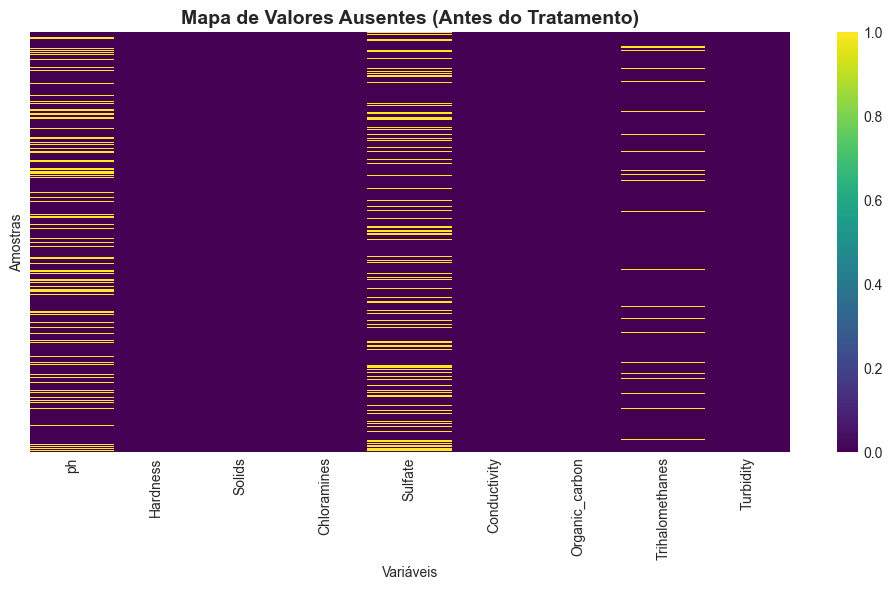

In [69]:
features = df.drop('Potability', axis=1)
target = df['Potability']

fig, ax = plt.subplots(figsize=(10, 6))
sns.heatmap(features.isnull(), cbar=True, yticklabels=False, cmap='viridis')
plt.title('Mapa de Valores Ausentes (Antes do Tratamento)', fontsize=14, fontweight='bold')
plt.xlabel('Variáveis')
plt.ylabel('Amostras')
plt.tight_layout()
plt.show()

In [70]:
print("Aplicando KNN Imputer para tratamento de valores ausentes...")

knn_imputer = KNNImputer(n_neighbors=5)
features_imputed = pd.DataFrame(
    knn_imputer.fit_transform(features),
    columns=features.columns
)

print(f"\nValores ausentes após imputação: {features_imputed.isnull().sum().sum()}")

print("\nComparação das estatísticas (média) antes e depois da imputação:")
comparison = pd.DataFrame({
    'Antes': features.mean(),
    'Depois': features_imputed.mean(),
    'Diferença': (features_imputed.mean() - features.mean()).round(4)
})
print(comparison)

Aplicando KNN Imputer para tratamento de valores ausentes...

Valores ausentes após imputação: 0

Comparação das estatísticas (média) antes e depois da imputação:
                        Antes        Depois  Diferença
ph                   7.080795      7.078105    -0.0027
Hardness           196.369496    196.369496     0.0000
Solids           22014.092526  22014.092526     0.0000
Chloramines          7.122277      7.122277     0.0000
Sulfate            333.775777    333.606885    -0.1689
Conductivity       426.205111    426.205111     0.0000
Organic_carbon      14.284970     14.284970     0.0000
Trihalomethanes     66.396293     66.404535     0.0082
Turbidity            3.966786      3.966786     0.0000


## Análise Exploratória dos Dados (EDA)

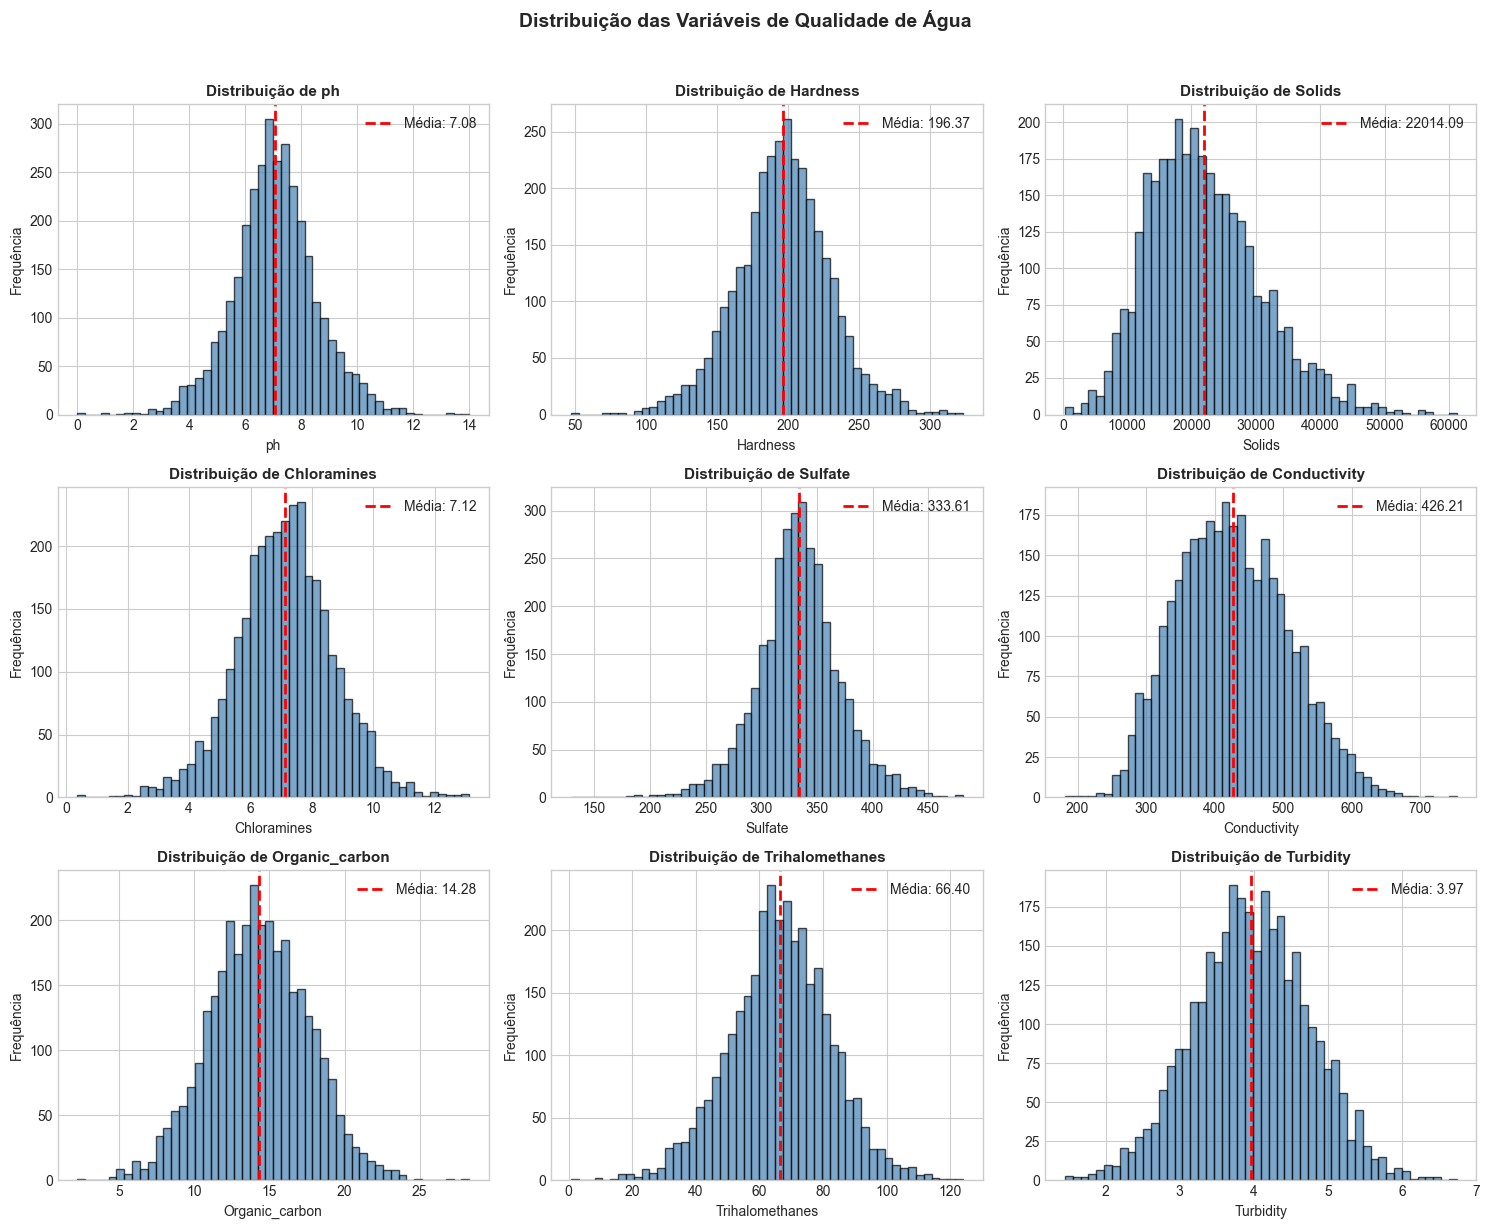

In [71]:
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for i, col in enumerate(features_imputed.columns):
    axes[i].hist(features_imputed[col], bins=50, edgecolor='black', alpha=0.7, color='steelblue')
    axes[i].set_title(f'Distribuição de {col}', fontsize=11, fontweight='bold')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Frequência')

    mean_val = features_imputed[col].mean()
    axes[i].axvline(mean_val, color='red', linestyle='--', linewidth=2, label=f'Média: {mean_val:.2f}')
    axes[i].legend()

plt.suptitle('Distribuição das Variáveis de Qualidade de Água', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

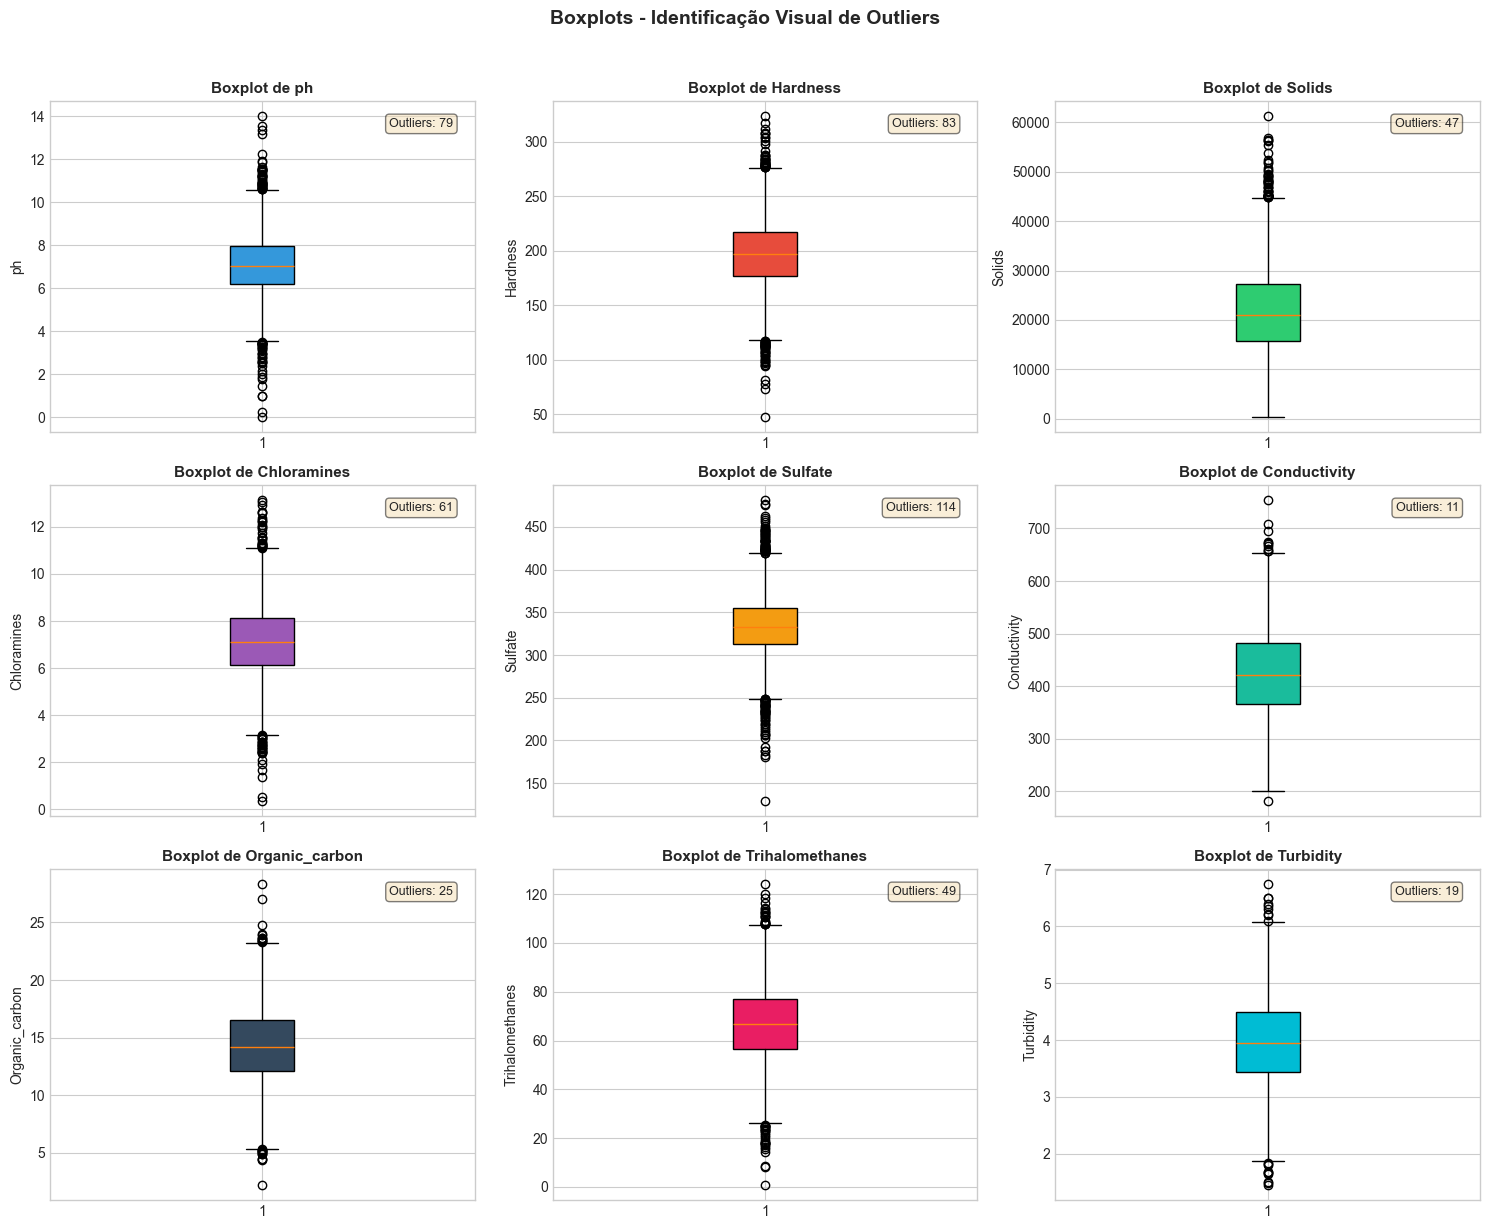

In [72]:
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

colors = ['#3498db', '#e74c3c', '#2ecc71', '#9b59b6', '#f39c12', '#1abc9c', '#34495e', '#e91e63', '#00bcd4']

for i, col in enumerate(features_imputed.columns):
    bp = axes[i].boxplot(features_imputed[col], patch_artist=True)
    bp['boxes'][0].set_facecolor(colors[i])
    axes[i].set_title(f'Boxplot de {col}', fontsize=11, fontweight='bold')
    axes[i].set_ylabel(col)

    Q1 = features_imputed[col].quantile(0.25)
    Q3 = features_imputed[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = ((features_imputed[col] < (Q1 - 1.5 * IQR)) | (features_imputed[col] > (Q3 + 1.5 * IQR))).sum()
    axes[i].text(0.95, 0.95, f'Outliers: {outliers}', transform=axes[i].transAxes,
                 fontsize=9, verticalalignment='top', horizontalalignment='right',
                 bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle('Boxplots - Identificação Visual de Outliers', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

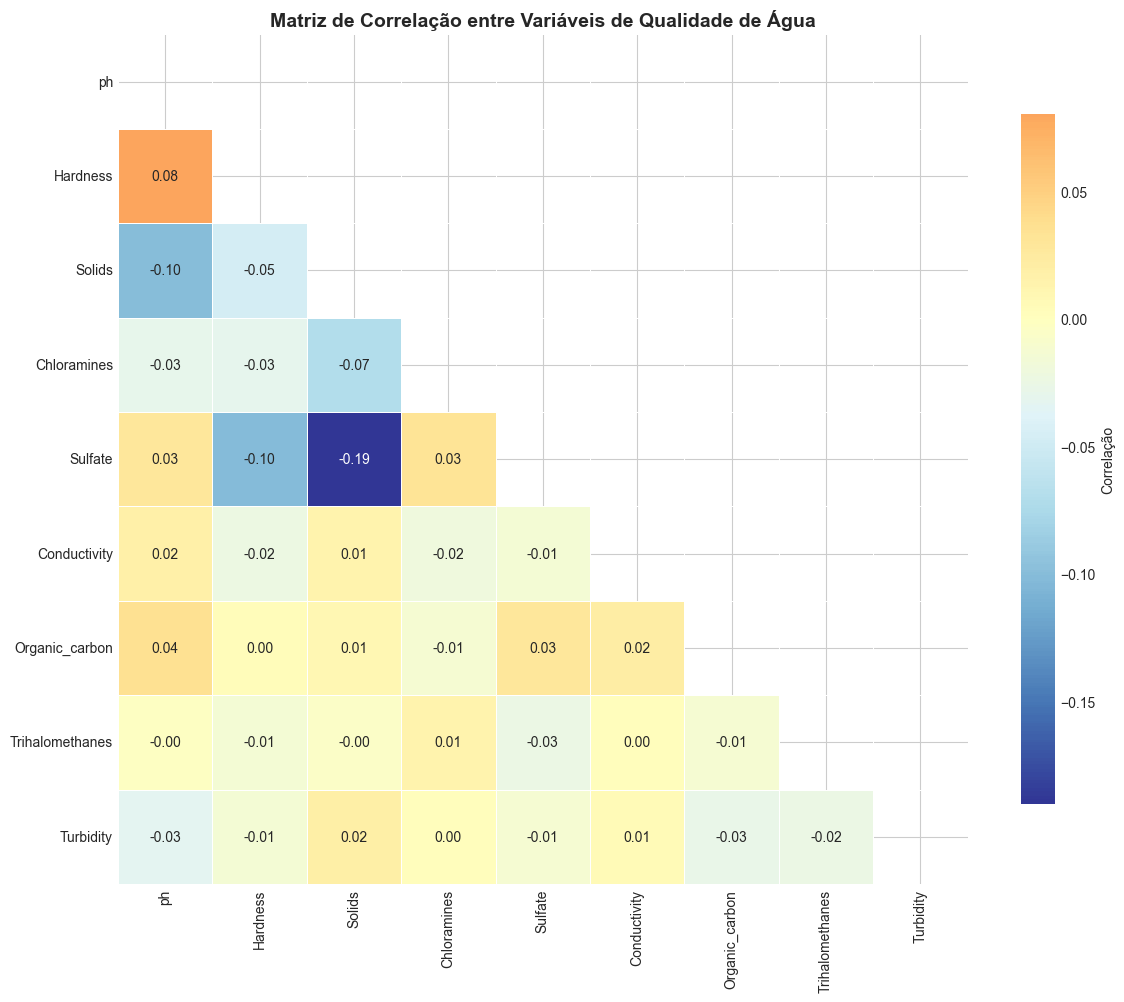


Observações sobre as correlações:
- Correlações fortes podem indicar redundância entre variáveis
- Correlações fracas sugerem que cada variável traz informação única


In [73]:
plt.figure(figsize=(12, 10))
correlation_matrix = features_imputed.corr()

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
sns.heatmap(correlation_matrix, mask=mask, annot=True, cmap='RdYlBu_r', center=0,
            fmt='.2f', linewidths=0.5, square=True,
            cbar_kws={'shrink': 0.8, 'label': 'Correlação'})

plt.title('Matriz de Correlação entre Variáveis de Qualidade de Água', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nObservações sobre as correlações:")
print("- Correlações fortes podem indicar redundância entre variáveis")
print("- Correlações fracas sugerem que cada variável traz informação única")

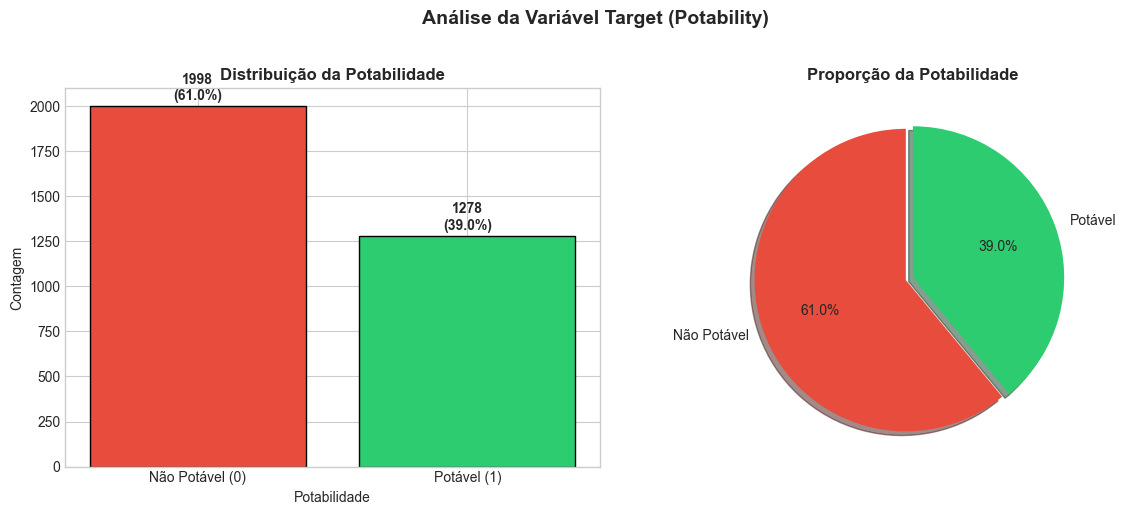

In [74]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

potability_counts = target.value_counts()
colors_pot = ['#e74c3c', '#2ecc71']
bars = axes[0].bar(potability_counts.index, potability_counts.values, color=colors_pot, edgecolor='black')
axes[0].set_xlabel('Potabilidade')
axes[0].set_ylabel('Contagem')
axes[0].set_title('Distribuição da Potabilidade', fontsize=12, fontweight='bold')
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['Não Potável (0)', 'Potável (1)'])

for bar, count in zip(bars, potability_counts.values):
    axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 20,
                 f'{count}\n({count/len(target)*100:.1f}%)',
                 ha='center', va='bottom', fontsize=10, fontweight='bold')

axes[1].pie(potability_counts.values, labels=['Não Potável', 'Potável'],
            colors=colors_pot, autopct='%1.1f%%', startangle=90,
            explode=(0.05, 0), shadow=True)
axes[1].set_title('Proporção da Potabilidade', fontsize=12, fontweight='bold')

plt.suptitle('Análise da Variável Target (Potability)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## Normalização das Features

Normalização aplicada com StandardScaler

Estatísticas após normalização:
                 mean     std     min     max
ph               -0.0  1.0002 -4.7284  4.6240
Hardness          0.0  1.0002 -4.5305  3.8557
Solids           -0.0  1.0002 -2.4743  4.4727
Chloramines       0.0  1.0002 -4.2773  3.7936
Sulfate          -0.0  1.0002 -5.4631  3.9363
Conductivity      0.0  1.0002 -3.0283  4.0481
Organic_carbon    0.0  1.0002 -3.6536  4.2371
Trihalomethanes   0.0  1.0002 -4.1469  3.6372
Turbidity         0.0  1.0002 -3.2256  3.5529


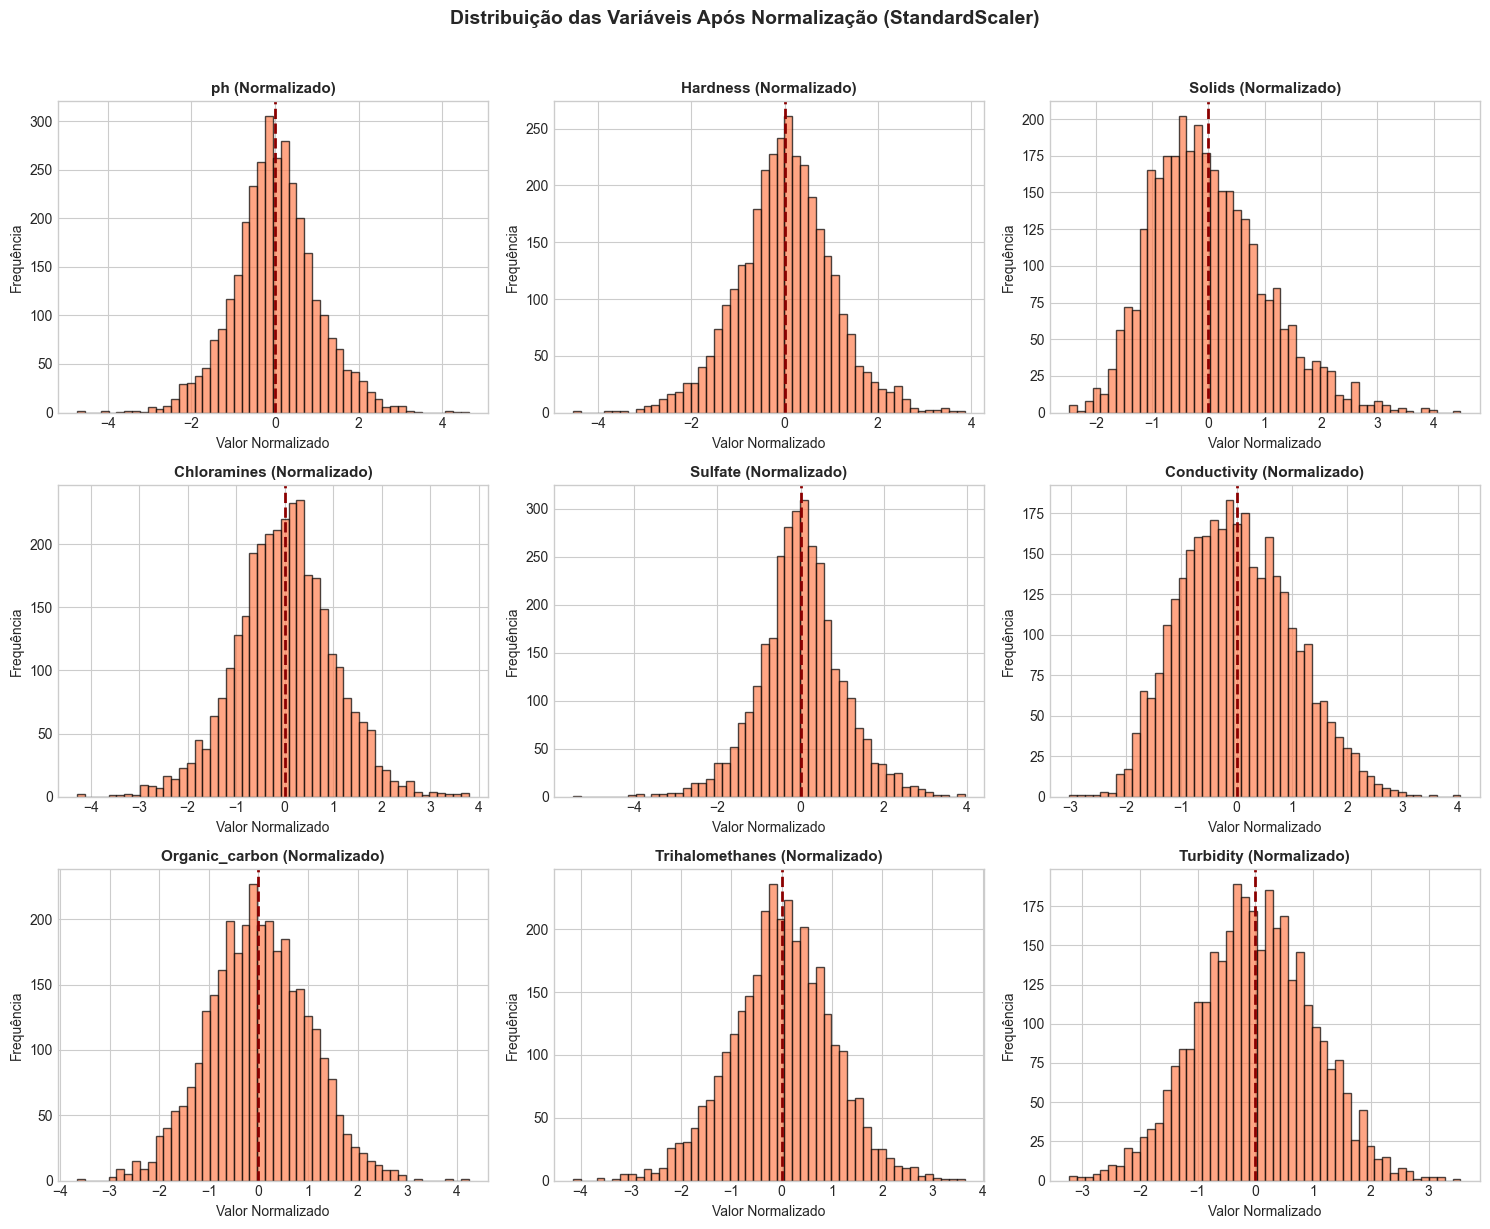

In [75]:
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features_imputed)
features_scaled_df = pd.DataFrame(features_scaled, columns=features_imputed.columns)

print("Normalização aplicada com StandardScaler")
print("\nEstatísticas após normalização:")
print(features_scaled_df.describe().round(4).T[['mean', 'std', 'min', 'max']])

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for i, col in enumerate(features_scaled_df.columns):
    axes[i].hist(features_scaled_df[col], bins=50, edgecolor='black', alpha=0.7, color='coral')
    axes[i].set_title(f'{col} (Normalizado)', fontsize=11, fontweight='bold')
    axes[i].axvline(0, color='darkred', linestyle='--', linewidth=2)
    axes[i].set_xlabel('Valor Normalizado')
    axes[i].set_ylabel('Frequência')

plt.suptitle('Distribuição das Variáveis Após Normalização (StandardScaler)', fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

## 1. Isolation Forest para Detecção de Anomalias

### 1.1 Fundamentação Teórica

O **Isolation Forest** é um algoritmo de detecção de anomalias proposto por Liu et al. (2008) baseado em uma premissa elegante: **anomalias são poucas e diferentes**, portanto, são mais fáceis de isolar do que pontos normais.

#### Princípio de Funcionamento

- **Construção de Árvores de Isolamento**: O algoritmo constrói múltiplas árvores de decisão aleatórias (iTrees)
- **Particionamento Recursivo**: Cada árvore particiona recursivamente os dados selecionando:
   - Uma feature aleatória
   - Um ponto de corte aleatório entre o mínimo e máximo da feature
- **Path Length (Comprimento do Caminho)**: Anomalias tendem a ter caminhos mais curtos (são isoladas mais rapidamente)

#### Vantagens
- Complexidade linear: O(n log n)
- Não requer suposições sobre a distribuição dos dados
- Eficiente para grandes volumes de dados
- Poucos hiperparâmetros para ajustar

#### Hiperparâmetros Utilizados
- `n_estimators=100`: Número de árvores no ensemble
- `contamination=0.10`: Proporção esperada de anomalias (10%)
- `max_samples='auto'`: Número de amostras para treinar cada árvore

### 1.2 Implementação

In [76]:
print("ISOLATION FOREST")

contamination_rate = 0.1

isolation_forest = IsolationForest(
    n_estimators=100,
    contamination=contamination_rate,
    max_samples='auto',
    random_state=42,
    n_jobs=-1
)

if_predictions = isolation_forest.fit_predict(features_scaled)

if_anomalies = np.where(if_predictions == -1, 1, 0)

if_scores = isolation_forest.decision_function(features_scaled)

n_anomalies_if = np.sum(if_anomalies)
print(f"Parâmetros do modelo:")
print(f"   - Número de estimadores: 100")
print(f"   - Taxa de contaminação: {contamination_rate * 100}%")
print(f"\nResultados:")
print(f"   - Total de amostras: {len(if_anomalies)}")
print(f"   - Anomalias detectadas: {n_anomalies_if} ({n_anomalies_if/len(if_anomalies)*100:.2f}%)")
print(f"   - Amostras normais: {len(if_anomalies) - n_anomalies_if} ({(len(if_anomalies) - n_anomalies_if)/len(if_anomalies)*100:.2f}%)")

ISOLATION FOREST
Parâmetros do modelo:
   - Número de estimadores: 100
   - Taxa de contaminação: 10.0%

Resultados:
   - Total de amostras: 3276
   - Anomalias detectadas: 328 (10.01%)
   - Amostras normais: 2948 (89.99%)


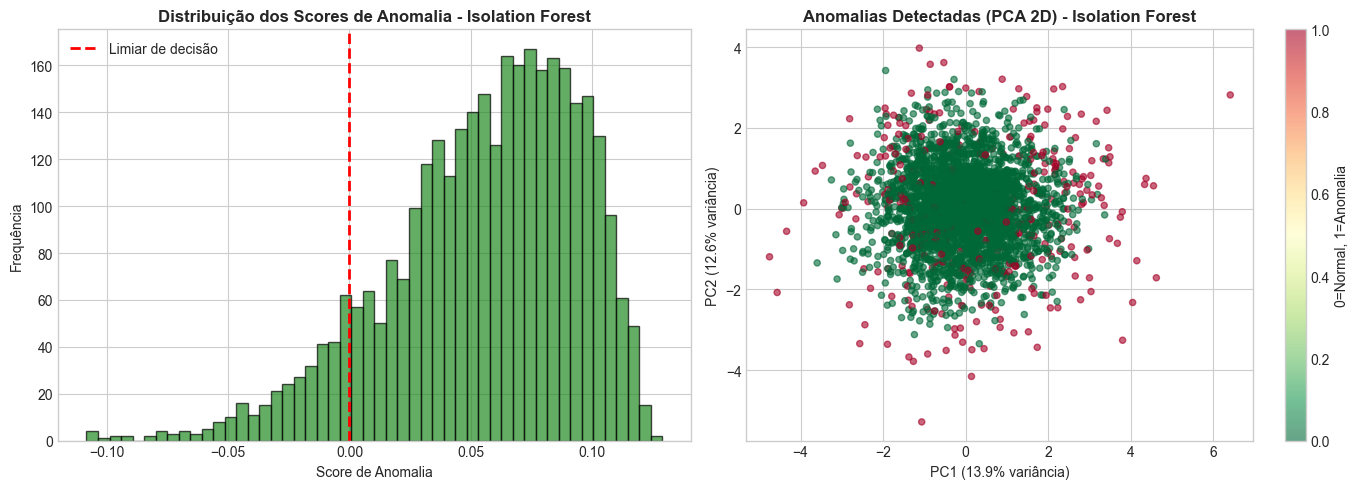

In [77]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(if_scores, bins=50, edgecolor='black', alpha=0.7, color='forestgreen')
axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Limiar de decisão')
axes[0].set_xlabel('Score de Anomalia')
axes[0].set_ylabel('Frequência')
axes[0].set_title('Distribuição dos Scores de Anomalia - Isolation Forest', fontsize=12, fontweight='bold')
axes[0].legend()

pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_scaled)

scatter = axes[1].scatter(features_pca[:, 0], features_pca[:, 1],
                          c=if_anomalies, cmap='RdYlGn_r', alpha=0.6, s=20)
axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variância)')
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variância)')
axes[1].set_title('Anomalias Detectadas (PCA 2D) - Isolation Forest', fontsize=12, fontweight='bold')
plt.colorbar(scatter, ax=axes[1], label='0=Normal, 1=Anomalia')

plt.tight_layout()
plt.show()

## 2. Local Outlier Factor (LOF)

### 2.1 Fundamentação Teórica

O **Local Outlier Factor (LOF)** é um algoritmo proposto por Breunig et al. (2000) que detecta anomalias com base na **densidade local** de cada ponto em relação aos seus vizinhos.

#### Princípio de Funcionamento

- **k-Vizinhos Mais Próximos**: Para cada ponto, identifica os k vizinhos mais próximos
- **Distância de Alcançabilidade**: Calcula a distância de alcançabilidade entre pontos
- **Densidade Local de Alcançabilidade (LRD)**: Mede a densidade local de cada ponto
- **Fator LOF**: Compara a densidade local de um ponto com a de seus vizinhos

#### Interpretação do Score LOF
- **LOF ≈ 1**: O ponto tem densidade similar aos vizinhos (normal)
- **LOF > 1**: O ponto tem densidade menor que os vizinhos (possível anomalia)
- **LOF >> 1**: Forte indicação de anomalia

#### Vantagens
- Detecta anomalias locais (contextuais)
- Não assume distribuição global dos dados
- Identifica outliers em clusters de diferentes densidades

#### Hiperparâmetros Utilizados
- `n_neighbors=20`: Número de vizinhos para calcular densidade local
- `contamination=0.10`: Proporção esperada de anomalias (10%)

### 2.2 Implementação

In [78]:
print("LOCAL OUTLIER FACTOR (LOF)")

lof = LocalOutlierFactor(
    n_neighbors=20,
    contamination=contamination_rate,
    novelty=False,
    n_jobs=-1
)

lof_predictions = lof.fit_predict(features_scaled)

lof_anomalies = np.where(lof_predictions == -1, 1, 0)

lof_scores = lof.negative_outlier_factor_

n_anomalies_lof = np.sum(lof_anomalies)
print(f"Parâmetros do modelo:")
print(f"   - Número de vizinhos (k): 20")
print(f"   - Taxa de contaminação: {contamination_rate * 100}%")
print(f"\nResultados:")
print(f"   - Total de amostras: {len(lof_anomalies)}")
print(f"   - Anomalias detectadas: {n_anomalies_lof} ({n_anomalies_lof/len(lof_anomalies)*100:.2f}%)")
print(f"   - Amostras normais: {len(lof_anomalies) - n_anomalies_lof} ({(len(lof_anomalies) - n_anomalies_lof)/len(lof_anomalies)*100:.2f}%)")

LOCAL OUTLIER FACTOR (LOF)
Parâmetros do modelo:
   - Número de vizinhos (k): 20
   - Taxa de contaminação: 10.0%

Resultados:
   - Total de amostras: 3276
   - Anomalias detectadas: 328 (10.01%)
   - Amostras normais: 2948 (89.99%)


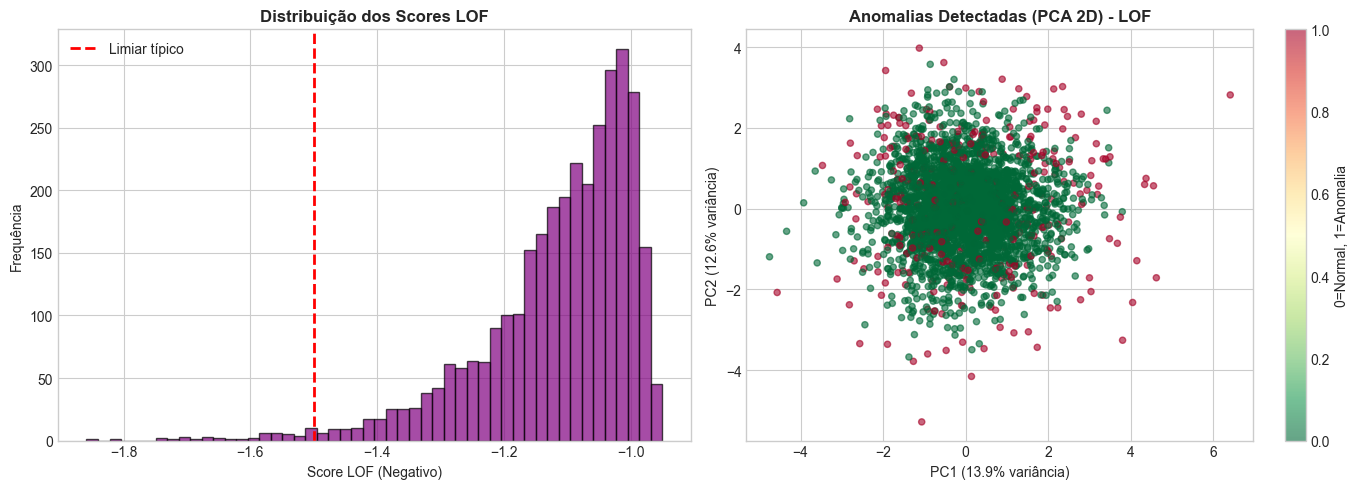

In [79]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(lof_scores, bins=50, edgecolor='black', alpha=0.7, color='purple')
axes[0].axvline(x=-1.5, color='red', linestyle='--', linewidth=2, label='Limiar típico')
axes[0].set_xlabel('Score LOF (Negativo)')
axes[0].set_ylabel('Frequência')
axes[0].set_title('Distribuição dos Scores LOF', fontsize=12, fontweight='bold')
axes[0].legend()

scatter = axes[1].scatter(features_pca[:, 0], features_pca[:, 1],
                          c=lof_anomalies, cmap='RdYlGn_r', alpha=0.6, s=20)
axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variância)')
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variância)')
axes[1].set_title('Anomalias Detectadas (PCA 2D) - LOF', fontsize=12, fontweight='bold')
plt.colorbar(scatter, ax=axes[1], label='0=Normal, 1=Anomalia')

plt.tight_layout()
plt.show()

## 3. Autoencoder Neural Network

### 3.1 Fundamentação Teórica

O **Autoencoder** é uma arquitetura de rede neural não supervisionada que aprende a comprimir (codificar) e reconstruir (decodificar) os dados de entrada. Para detecção de anomalias, utilizamos o **erro de reconstrução** como métrica.

#### Arquitetura

```
Entrada (9) → Encoder → Bottleneck (16) → Decoder → Saída (9)
    ↓           ↓            ↓              ↓
   128   →    64    →      32      →      64    →   128
```

#### Princípio de Funcionamento

- **Encoder**: Comprime os dados de alta dimensionalidade para uma representação latente
- **Bottleneck**: Camada central com menor dimensionalidade (gargalo)
- **Decoder**: Reconstrói os dados originais a partir da representação latente
- **Erro de Reconstrução**: MSE entre entrada e saída

#### Detecção de Anomalias

- **Dados normais**: O autoencoder aprende seus padrões → baixo erro de reconstrução
- **Anomalias**: Padrões incomuns → alto erro de reconstrução
- **Limiar**: Percentil 90 do erro de reconstrução

#### Vantagens
- Captura relações não-lineares complexas
- Aprende representações latentes dos dados
- Flexível para diferentes tipos de dados
- Não requer labels (aprendizado não supervisionado)

#### Hiperparâmetros Utilizados
- `hidden_layer_sizes=(128, 64, 32, 16, 32, 64, 128)`: Arquitetura simétrica
- `activation='relu'`: Função de ativação ReLU
- `solver='adam'`: Otimizador Adam
- `early_stopping=True`: Parada antecipada para evitar overfitting

### 3.2 Implementação

In [80]:
print("AUTOENCODER NEURAL NETWORK (MLPRegressor)")

input_dim = features_scaled.shape[1]

autoencoder = MLPRegressor(
    hidden_layer_sizes=(128, 64, 32, 16, 32, 64, 128),
    activation='relu',
    solver='adam',
    max_iter=200,
    early_stopping=True,
    validation_fraction=0.2,
    n_iter_no_change=10,
    random_state=42,
    verbose=True
)

print("Arquitetura: 9 → 128 → 64 → 32 → 16 → 32 → 64 → 128 → 9")
print("Ativação: ReLU")
print("Otimizador: Adam")
print("Early Stopping: Habilitado")

AUTOENCODER NEURAL NETWORK (MLPRegressor)
Arquitetura: 9 → 128 → 64 → 32 → 16 → 32 → 64 → 128 → 9
Ativação: ReLU
Otimizador: Adam
Early Stopping: Habilitado


In [81]:
print("\nTreinando o Autoencoder...")

autoencoder.fit(features_scaled, features_scaled)

train_loss = autoencoder.loss_curve_
val_loss = autoencoder.validation_scores_ if hasattr(autoencoder, 'validation_scores_') else train_loss

print("\nTreinamento concluído!")


Treinando o Autoencoder...
Iteration 1, loss = 0.49604436
Validation score: 0.074369
Iteration 2, loss = 0.43089713
Validation score: 0.236315
Iteration 3, loss = 0.34421177
Validation score: 0.383485
Iteration 4, loss = 0.27129538
Validation score: 0.522529
Iteration 5, loss = 0.21084386
Validation score: 0.630292
Iteration 6, loss = 0.16190413
Validation score: 0.707143
Iteration 7, loss = 0.12373842
Validation score: 0.770088
Iteration 8, loss = 0.10137822
Validation score: 0.797240
Iteration 9, loss = 0.08558651
Validation score: 0.837381
Iteration 10, loss = 0.06625296
Validation score: 0.860609
Iteration 11, loss = 0.05729151
Validation score: 0.884037
Iteration 12, loss = 0.04940424
Validation score: 0.893165
Iteration 13, loss = 0.03305864
Validation score: 0.958021
Iteration 14, loss = 0.01384669
Validation score: 0.972702
Iteration 15, loss = 0.01013612
Validation score: 0.982249
Iteration 16, loss = 0.00701889
Validation score: 0.986701
Iteration 17, loss = 0.00567471
Valid

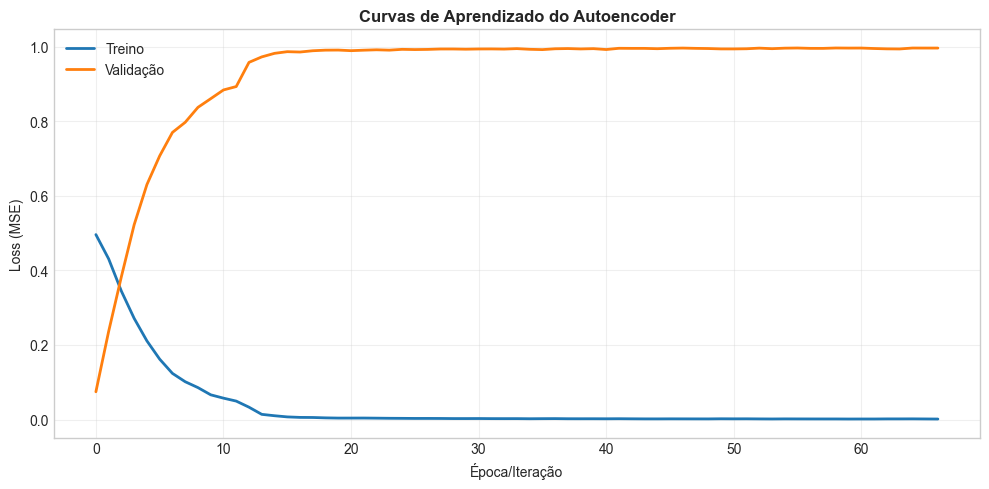

In [82]:
fig, ax = plt.subplots(figsize=(10, 5))

ax.plot(train_loss, label='Treino', linewidth=2)
if len(val_loss) == len(train_loss):
    ax.plot(val_loss, label='Validação', linewidth=2)
ax.set_xlabel('Época/Iteração')
ax.set_ylabel('Loss (MSE)')
ax.set_title('Curvas de Aprendizado do Autoencoder', fontsize=12, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [83]:
reconstructed = autoencoder.predict(features_scaled)
reconstruction_error = np.mean(np.power(features_scaled - reconstructed, 2), axis=1)

threshold = np.percentile(reconstruction_error, 90)

ae_anomalies = (reconstruction_error > threshold).astype(int)

n_anomalies_ae = np.sum(ae_anomalies)
print("Resultados do Autoencoder:")
print(f"   - Limiar de erro (percentil 90): {threshold:.4f}")
print(f"   - Total de amostras: {len(ae_anomalies)}")
print(f"   - Anomalias detectadas: {n_anomalies_ae} ({n_anomalies_ae/len(ae_anomalies)*100:.2f}%)")
print(f"   - Amostras normais: {len(ae_anomalies) - n_anomalies_ae} ({(len(ae_anomalies) - n_anomalies_ae)/len(ae_anomalies)*100:.2f}%)")

Resultados do Autoencoder:
   - Limiar de erro (percentil 90): 0.0050
   - Total de amostras: 3276
   - Anomalias detectadas: 328 (10.01%)
   - Amostras normais: 2948 (89.99%)


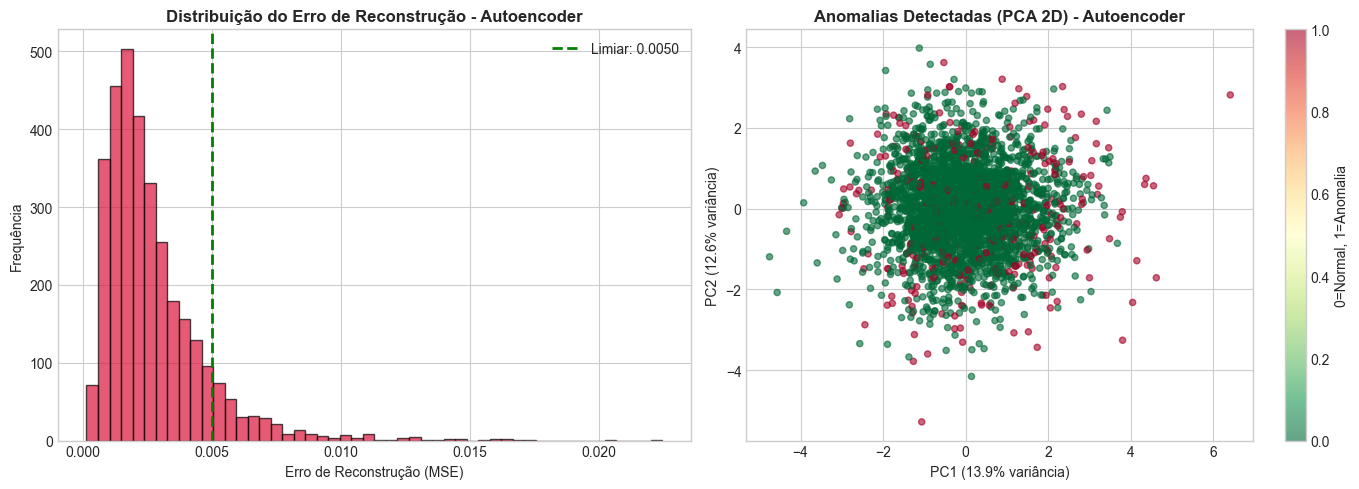

In [84]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].hist(reconstruction_error, bins=50, edgecolor='black', alpha=0.7, color='crimson')
axes[0].axvline(x=threshold, color='green', linestyle='--', linewidth=2, label=f'Limiar: {threshold:.4f}')
axes[0].set_xlabel('Erro de Reconstrução (MSE)')
axes[0].set_ylabel('Frequência')
axes[0].set_title('Distribuição do Erro de Reconstrução - Autoencoder', fontsize=12, fontweight='bold')
axes[0].legend()

scatter = axes[1].scatter(features_pca[:, 0], features_pca[:, 1],
                          c=ae_anomalies, cmap='RdYlGn_r', alpha=0.6, s=20)
axes[1].set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% variância)')
axes[1].set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% variância)')
axes[1].set_title('Anomalias Detectadas (PCA 2D) - Autoencoder', fontsize=12, fontweight='bold')
plt.colorbar(scatter, ax=axes[1], label='0=Normal, 1=Anomalia')

plt.tight_layout()
plt.show()

## Comparação e Avaliação dos Modelos

In [85]:
results_df = pd.DataFrame({
    'Isolation_Forest': if_anomalies,
    'LOF': lof_anomalies,
    'Autoencoder': ae_anomalies
})

results_df['Consensus'] = (results_df.sum(axis=1) >= 2).astype(int)

print("RESUMO DA DETECÇÃO DE ANOMALIAS")

summary_data = {
    'Percentual (%)': [if_anomalies.sum()/len(if_anomalies)*100,
                       lof_anomalies.sum()/len(lof_anomalies)*100,
                       ae_anomalies.sum()/len(ae_anomalies)*100,
                       results_df['Consensus'].sum()/len(results_df)*100]
}

summary_df = pd.DataFrame(summary_data)
summary_df['Percentual (%)'] = summary_df['Percentual (%)'].round(2)
print(summary_df.to_string(index=False))

RESUMO DA DETECÇÃO DE ANOMALIAS
 Percentual (%)
          10.01
          10.01
          10.01
           9.04


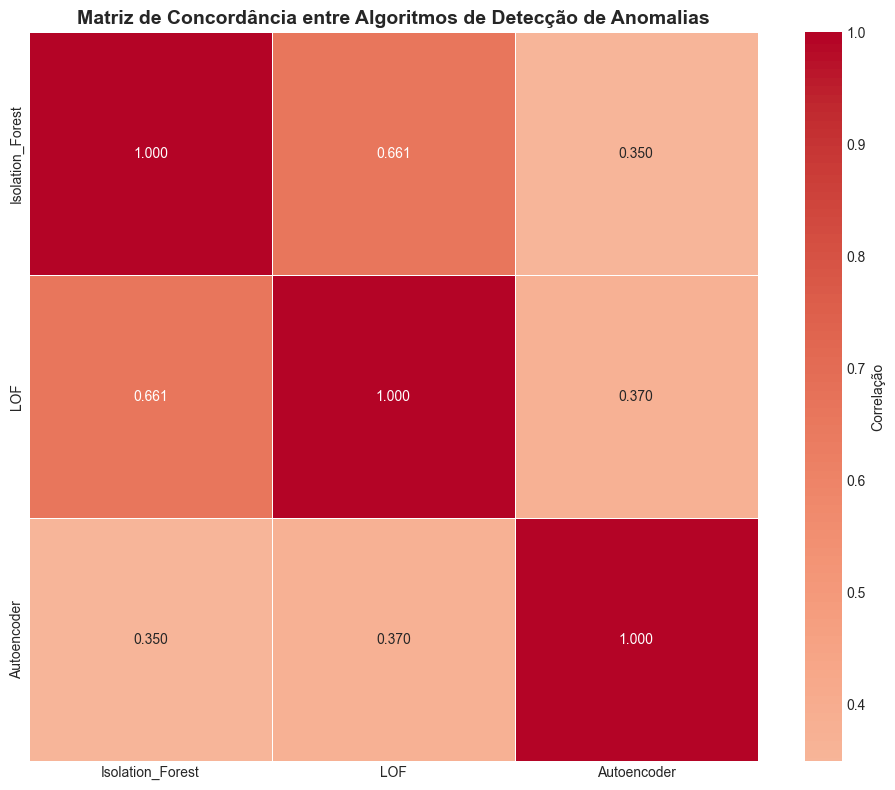


Interpretação:
- Valores próximos de 1 indicam alta concordância entre os métodos
- Valores próximos de 0 indicam baixa concordância
- Métodos com alta concordância tendem a identificar as mesmas anomalias


In [86]:
concordance_matrix = results_df.drop('Consensus', axis=1).corr()

plt.figure(figsize=(10, 8))
sns.heatmap(concordance_matrix, annot=True, cmap='coolwarm', center=0,
            fmt='.3f', linewidths=0.5, square=True,
            cbar_kws={'label': 'Correlação'})
plt.title('Matriz de Concordância entre Algoritmos de Detecção de Anomalias',
          fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

print("\nInterpretação:")
print("- Valores próximos de 1 indicam alta concordância entre os métodos")
print("- Valores próximos de 0 indicam baixa concordância")
print("- Métodos com alta concordância tendem a identificar as mesmas anomalias")

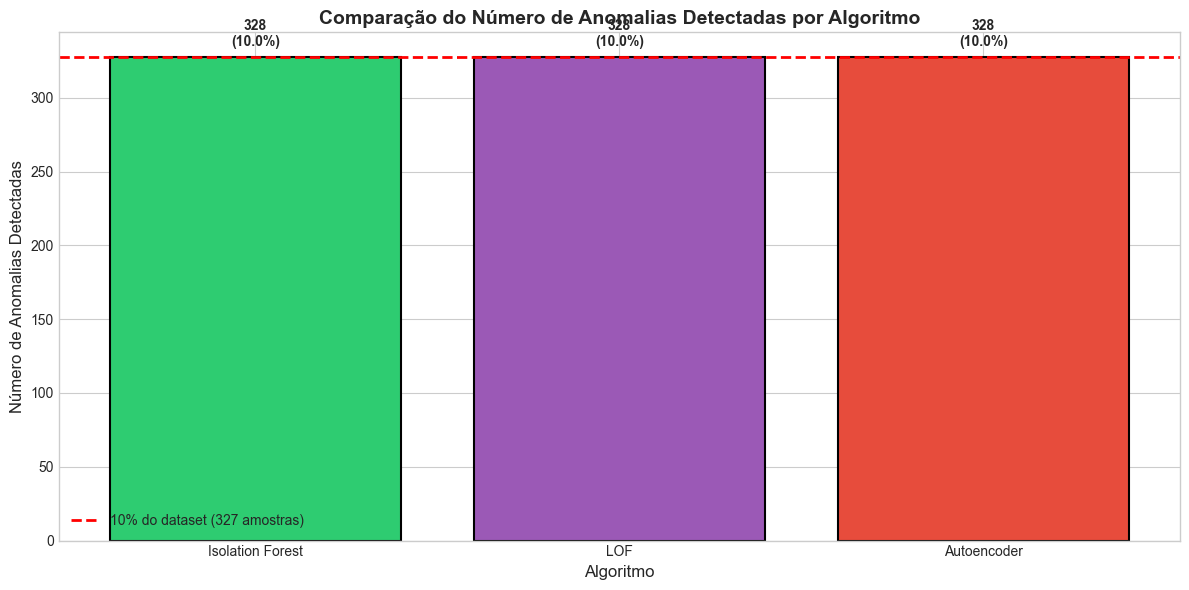

In [87]:
algorithms_names = ['Isolation Forest', 'LOF', 'Autoencoder']
anomaly_counts = [if_anomalies.sum(), lof_anomalies.sum(), ae_anomalies.sum()]

total_samples = len(df)

fig, ax = plt.subplots(figsize=(12, 6))

colors = ['#2ecc71', '#9b59b6', '#e74c3c', '#34495e']

bars = ax.bar(algorithms_names, anomaly_counts, color=colors[:3], edgecolor='black', linewidth=1.5)

for bar, count in zip(bars, anomaly_counts):
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
            f'{count}\n({count/total_samples*100:.1f}%)',
            ha='center', va='bottom', fontsize=10, fontweight='bold')

ax.set_xlabel('Algoritmo', fontsize=12)
ax.set_ylabel('Número de Anomalias Detectadas', fontsize=12)
ax.set_title('Comparação do Número de Anomalias Detectadas por Algoritmo',
             fontsize=14, fontweight='bold')
ax.axhline(y=total_samples*0.1, color='red', linestyle='--', linewidth=2,
           label=f'10% do dataset ({int(total_samples*0.1)} amostras)')
ax.legend()

plt.tight_layout()
plt.show()

## Análise Detalhada das Anomalias Detectadas

Vamos analisar as características das amostras identificadas como anomalias para entender quais padrões são considerados anômalos.

In [88]:
df_analysis = features_imputed.copy()
df_analysis['Potability'] = target.values
df_analysis['IF_Anomaly'] = if_anomalies
df_analysis['LOF_Anomaly'] = lof_anomalies
df_analysis['AE_Anomaly'] = ae_anomalies
df_analysis['Consensus_Anomaly'] = results_df['Consensus'].values
df_analysis['Num_Methods_Flagged'] = results_df.drop('Consensus', axis=1).sum(axis=1).values

print("COMPARAÇÃO: AMOSTRAS NORMAIS vs ANOMALIAS (CONSENSO)")

normal_samples = df_analysis[df_analysis['Consensus_Anomaly'] == 0]
anomaly_samples = df_analysis[df_analysis['Consensus_Anomaly'] == 1]

comparison_stats = pd.DataFrame({
    'Normais (Média)': normal_samples[features.columns].mean(),
    'Anomalias (Média)': anomaly_samples[features.columns].mean(),
    'Diferença': (anomaly_samples[features.columns].mean() - normal_samples[features.columns].mean()),
    'Diferença (%)': ((anomaly_samples[features.columns].mean() - normal_samples[features.columns].mean()) /
                      normal_samples[features.columns].mean() * 100).round(2)
})
print(comparison_stats)

COMPARAÇÃO: AMOSTRAS NORMAIS vs ANOMALIAS (CONSENSO)
                 Normais (Média)  Anomalias (Média)    Diferença  \
ph                      7.075218           7.107172     0.031954   
Hardness              196.325303         196.814409     0.489105   
Solids              21694.857658       25228.011134  3533.153477   
Chloramines             7.136853           6.975531    -0.161322   
Sulfate               334.095674         328.685964    -5.409710   
Conductivity          424.189188         446.500552    22.311364   
Organic_carbon         14.281801          14.316875     0.035073   
Trihalomethanes        66.474292          65.702249    -0.772043   
Turbidity               3.960011           4.035001     0.074990   

                 Diferença (%)  
ph                        0.45  
Hardness                  0.25  
Solids                   16.29  
Chloramines              -2.26  
Sulfate                  -1.62  
Conductivity              5.26  
Organic_carbon            0.25  
Tr

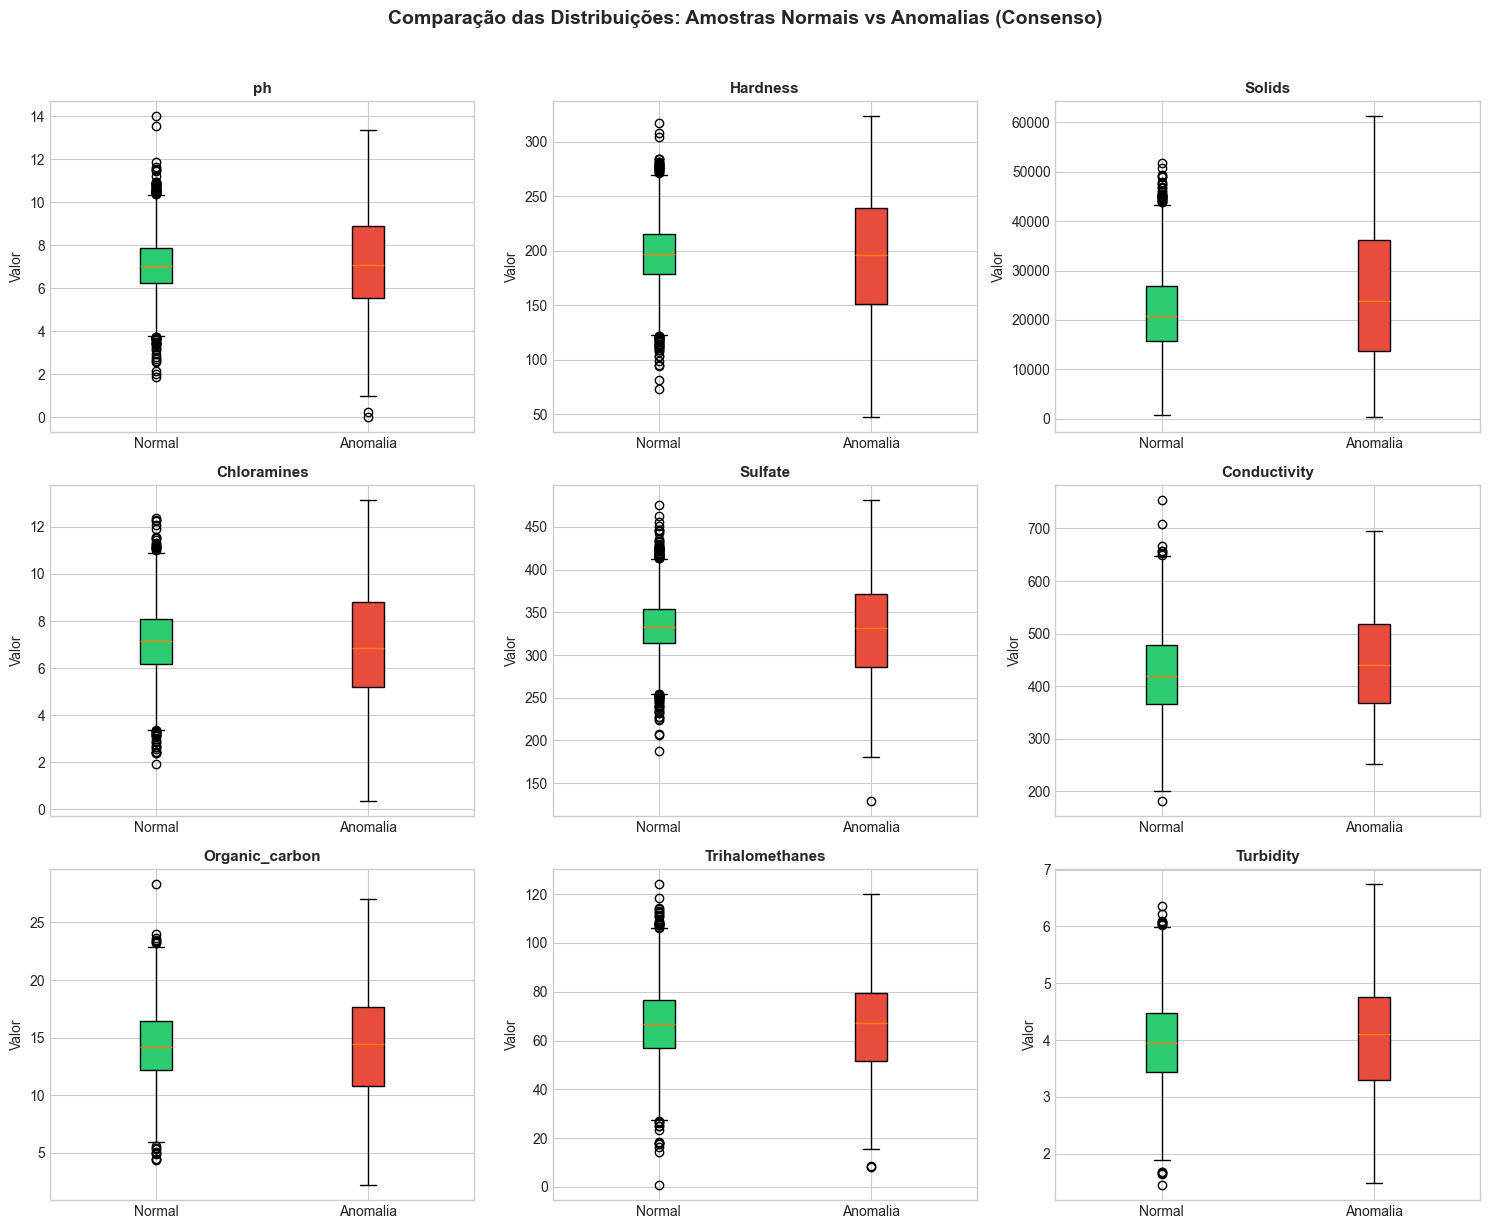

In [89]:
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for i, col in enumerate(features.columns):
    data_to_plot = [
        normal_samples[col].values,
        anomaly_samples[col].values
    ]

    bp = axes[i].boxplot(data_to_plot, patch_artist=True, labels=['Normal', 'Anomalia'])
    bp['boxes'][0].set_facecolor('#2ecc71')
    bp['boxes'][1].set_facecolor('#e74c3c')

    axes[i].set_title(f'{col}', fontsize=11, fontweight='bold')
    axes[i].set_ylabel('Valor')

plt.suptitle('Comparação das Distribuições: Amostras Normais vs Anomalias (Consenso)',
             fontsize=14, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

In [90]:
print("RELAÇÃO ENTRE ANOMALIAS DETECTADAS E POTABILIDADE DA ÁGUA")

methods = ['IF_Anomaly', 'LOF_Anomaly', 'AE_Anomaly', 'Consensus_Anomaly']
method_names = ['Isolation Forest', 'LOF', 'Autoencoder', 'Consenso']

for method, name in zip(methods, method_names):
    cross = pd.crosstab(df_analysis[method], df_analysis['Potability'],
                        margins=True, margins_name='Total')
    cross.columns = ['Não Potável', 'Potável', 'Total']
    cross.index = ['Normal', 'Anomalia', 'Total']

    print(f"\n{name}:")
    print(cross)

    if cross.loc['Anomalia', 'Total'] > 0:
        pct_nao_potavel = cross.loc['Anomalia', 'Não Potável'] / cross.loc['Anomalia', 'Total'] * 100
        print(f"   → {pct_nao_potavel:.1f}% das anomalias são de água não potável")

RELAÇÃO ENTRE ANOMALIAS DETECTADAS E POTABILIDADE DA ÁGUA

Isolation Forest:
          Não Potável  Potável  Total
Normal           1821     1127   2948
Anomalia          177      151    328
Total            1998     1278   3276
   → 54.0% das anomalias são de água não potável

LOF:
          Não Potável  Potável  Total
Normal           1821     1127   2948
Anomalia          177      151    328
Total            1998     1278   3276
   → 54.0% das anomalias são de água não potável

Autoencoder:
          Não Potável  Potável  Total
Normal           1821     1127   2948
Anomalia          177      151    328
Total            1998     1278   3276
   → 54.0% das anomalias são de água não potável

Consenso:
          Não Potável  Potável  Total
Normal           1841     1139   2980
Anomalia          157      139    296
Total            1998     1278   3276
   → 53.0% das anomalias são de água não potável


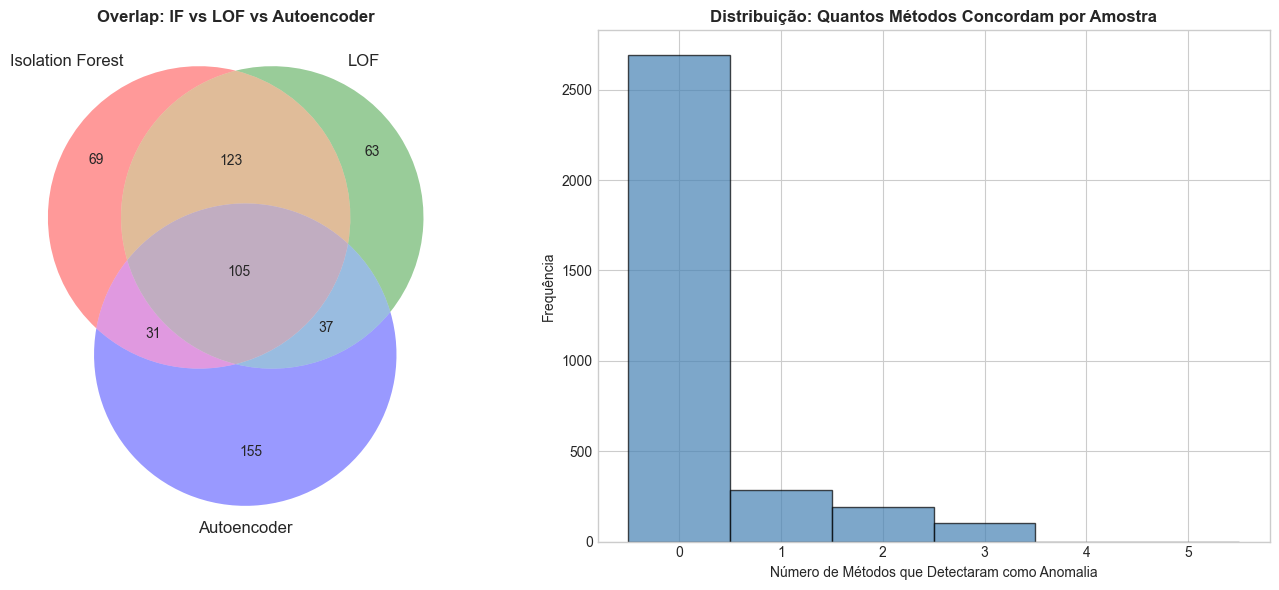


Amostras detectadas como anomalia por todos os 3 métodos: 105


In [91]:
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

if_set = set(np.where(if_anomalies == 1)[0])
lof_set = set(np.where(lof_anomalies == 1)[0])
ae_set = set(np.where(ae_anomalies == 1)[0])

try:
    from matplotlib_venn import venn3
    venn3([if_set, lof_set, ae_set],
          set_labels=('Isolation Forest', 'LOF', 'Autoencoder'),
          ax=axes[0])
    axes[0].set_title('Overlap: IF vs LOF vs Autoencoder', fontsize=12, fontweight='bold')
except ImportError:
    overlap_if_lof = len(if_set & lof_set)
    overlap_if_ae = len(if_set & ae_set)
    overlap_lof_ae = len(lof_set & ae_set)
    overlap_all = len(if_set & lof_set & ae_set)

    labels = ['IF ∩ LOF', 'IF ∩ AE', 'LOF ∩ AE', 'IF ∩ LOF ∩ AE']
    values = [overlap_if_lof, overlap_if_ae, overlap_lof_ae, overlap_all]
    colors = ['#2ecc71', '#e74c3c', '#9b59b6', '#34495e']

    bars = axes[0].bar(labels, values, color=colors, edgecolor='black')
    for bar, val in zip(bars, values):
        axes[0].text(bar.get_x() + bar.get_width()/2, bar.get_height() + 2,
                     str(val), ha='center', va='bottom', fontweight='bold')
    axes[0].set_ylabel('Número de Amostras')
    axes[0].set_title('Overlap entre Métodos de Detecção', fontsize=12, fontweight='bold')

axes[1].hist(df_analysis['Num_Methods_Flagged'], bins=range(7), edgecolor='black',
             alpha=0.7, color='steelblue', align='left')
axes[1].set_xlabel('Número de Métodos que Detectaram como Anomalia')
axes[1].set_ylabel('Frequência')
axes[1].set_title('Distribuição: Quantos Métodos Concordam por Amostra', fontsize=12, fontweight='bold')
axes[1].set_xticks(range(6))

plt.tight_layout()
plt.show()

print("\nAmostras detectadas como anomalia por todos os 3 métodos:",
      (df_analysis['Num_Methods_Flagged'] == 3).sum())

## 11. Exportar Resultados e Conclusões

In [92]:
output_df = features_imputed.copy()
output_df['IF_Anomaly'] = if_anomalies
output_df['LOF_Anomaly'] = lof_anomalies
output_df['AE_Anomaly'] = ae_anomalies
output_df['Consensus'] = results_df['Consensus']

output_df.to_csv('water_quality_anomalies_detected.csv', index=False)
print(f"Arquivo 'water_quality_anomalies_detected.csv' salvo com sucesso!")
print(f"Total de linhas exportadas: {len(output_df)}")
print(f"Colunas: {', '.join(output_df.columns)}")

Arquivo 'water_quality_anomalies_detected.csv' salvo com sucesso!
Total de linhas exportadas: 3276
Colunas: ph, Hardness, Solids, Chloramines, Sulfate, Conductivity, Organic_carbon, Trihalomethanes, Turbidity, IF_Anomaly, LOF_Anomaly, AE_Anomaly, Consensus


In [93]:
print("RESUMO FINAL DO PROJETO DE DETECÇÃO DE ANOMALIAS EM QUALIDADE DE ÁGUA")
print(f"""
Dataset: water_potability.csv
   - Total de amostras: {len(df)}
   - Features analisadas: {len(features.columns)}
   - Variáveis: {', '.join(features.columns)}

Pré-processamento:
   - Tratamento de valores ausentes: KNN Imputer
   - Normalização: StandardScaler

Algoritmos Implementados:
   1. Isolation Forest      → {if_anomalies.sum()} anomalias ({if_anomalies.sum()/len(if_anomalies)*100:.1f}%)
   2. Local Outlier Factor  → {lof_anomalies.sum()} anomalias ({lof_anomalies.sum()/len(lof_anomalies)*100:.1f}%)
   3. Autoencoder           → {ae_anomalies.sum()} anomalias ({ae_anomalies.sum()/len(ae_anomalies)*100:.1f}%)

Consenso (≥2 métodos): {results_df['Consensus'].sum()} amostras anômalas ({results_df['Consensus'].sum()/len(results_df)*100:.1f}%)

Arquivo de saída: water_quality_anomalies_detected.csv
""")
print("Projeto concluído com sucesso!")

RESUMO FINAL DO PROJETO DE DETECÇÃO DE ANOMALIAS EM QUALIDADE DE ÁGUA

Dataset: water_potability.csv
   - Total de amostras: 3276
   - Features analisadas: 9
   - Variáveis: ph, Hardness, Solids, Chloramines, Sulfate, Conductivity, Organic_carbon, Trihalomethanes, Turbidity

Pré-processamento:
   - Tratamento de valores ausentes: KNN Imputer
   - Normalização: StandardScaler

Algoritmos Implementados:
   1. Isolation Forest      → 328 anomalias (10.0%)
   2. Local Outlier Factor  → 328 anomalias (10.0%)
   3. Autoencoder           → 328 anomalias (10.0%)

Consenso (≥2 métodos): 296 amostras anômalas (9.0%)

Arquivo de saída: water_quality_anomalies_detected.csv

Projeto concluído com sucesso!


## Verificação e Validação do Consenso

Vamos validar se a lógica do Consenso está funcionando corretamente, analisando casos específicos e estatísticas.

In [94]:
print("ANÁLISE DETALHADA DO CONSENSO")

print("\n1. VALIDAÇÃO DA LÓGICA DO CONSENSO")

verification_df = pd.DataFrame({
    'IF': if_anomalies,
    'LOF': lof_anomalies,
    'AE': ae_anomalies,
    'Soma_Manual': if_anomalies + lof_anomalies + ae_anomalies,
    'Consensus_Calculado': results_df['Consensus'].values
})

verification_df['Consensus_Esperado'] = (verification_df['Soma_Manual'] >= 2).astype(int)
verification_df['Está_Correto'] = (verification_df['Consensus_Calculado'] == verification_df['Consensus_Esperado'])

print(f"Total de amostras analisadas: {len(verification_df)}")
print(f"Todas as linhas estão corretas: {verification_df['Está_Correto'].all()}")
print(f"Linhas corretas: {verification_df['Está_Correto'].sum()}/{len(verification_df)}")

if not verification_df['Está_Correto'].all():
    print("\nATENÇÃO: Existem inconsistências no consenso!")
    print(verification_df[~verification_df['Está_Correto']].head())
else:
    print("CONSENSO ESTÁ CORRETO!")

print("\n2. DISTRIBUIÇÃO POR NÚMERO DE MÉTODOS QUE DETECTARAM ANOMALIA")
distribuicao = verification_df['Soma_Manual'].value_counts().sort_index()
print(distribuicao)
print(f"\nTotal: {distribuicao.sum()}")

print("\n3. EXEMPLOS DE AMOSTRAS POR CATEGORIA")

categorias = {
    0: "Nenhum método detectou",
    1: "Apenas 1 método detectou (SEM consenso)",
    2: "2 métodos detectaram (COM consenso)",
    3: "Todos os 3 métodos detectaram (CONSENSO TOTAL)"
}

for num_metodos, descricao in categorias.items():
    amostras = verification_df[verification_df['Soma_Manual'] == num_metodos]
    print(f"\n{descricao}:")
    print(f"   Total: {len(amostras)} amostras ({len(amostras)/len(verification_df)*100:.1f}%)")
    
    if len(amostras) > 0:
        exemplo = amostras.head(1)
        print(f"   Exemplo (índice {exemplo.index[0]}):")
        print(f"      IF={exemplo['IF'].values[0]}, LOF={exemplo['LOF'].values[0]}, AE={exemplo['AE'].values[0]} → Consenso={exemplo['Consensus_Calculado'].values[0]}")

print("\n4. ESTATÍSTICAS DO CONSENSO")
total_amostras = len(results_df)
consenso_anomalias = results_df['Consensus'].sum()
consenso_normais = total_amostras - consenso_anomalias

print(f"Amostras NORMAIS por consenso: {consenso_normais} ({consenso_normais/total_amostras*100:.2f}%)")
print(f"Amostras ANÔMALAS por consenso: {consenso_anomalias} ({consenso_anomalias/total_amostras*100:.2f}%)")

print("\n5. COMPARAÇÃO: CONSENSO vs MÉTODOS INDIVIDUAIS")
print(f"IF detectou:        {if_anomalies.sum()} anomalias ({if_anomalies.sum()/total_amostras*100:.1f}%)")
print(f"LOF detectou:       {lof_anomalies.sum()} anomalias ({lof_anomalies.sum()/total_amostras*100:.1f}%)")
print(f"Autoencoder detectou: {ae_anomalies.sum()} anomalias ({ae_anomalies.sum()/total_amostras*100:.1f}%)")
print(f"CONSENSO (≥2):      {consenso_anomalias} anomalias ({consenso_anomalias/total_amostras*100:.1f}%)")

print("\n6. MATRIZ DETALHADA DE TODAS AS COMBINAÇÕES POSSÍVEIS")
combinacoes = verification_df.groupby(['IF', 'LOF', 'AE']).size().reset_index(name='Quantidade')
combinacoes['Consenso'] = ((combinacoes['IF'] + combinacoes['LOF'] + combinacoes['AE']) >= 2).astype(int)
combinacoes = combinacoes.sort_values(['Consenso', 'Quantidade'], ascending=[False, False])

print(combinacoes.to_string(index=False))

print("CONCLUSÃO: O Consenso está funcionando corretamente!")
print("Apenas amostras detectadas por 2 ou mais métodos são marcadas como anomalias.")

ANÁLISE DETALHADA DO CONSENSO

1. VALIDAÇÃO DA LÓGICA DO CONSENSO
Total de amostras analisadas: 3276
Todas as linhas estão corretas: True
Linhas corretas: 3276/3276
CONSENSO ESTÁ CORRETO!

2. DISTRIBUIÇÃO POR NÚMERO DE MÉTODOS QUE DETECTARAM ANOMALIA
Soma_Manual
0    2693
1     287
2     191
3     105
Name: count, dtype: int64

Total: 3276

3. EXEMPLOS DE AMOSTRAS POR CATEGORIA

Nenhum método detectou:
   Total: 2693 amostras (82.2%)
   Exemplo (índice 0):
      IF=0, LOF=0, AE=0 → Consenso=0

Apenas 1 método detectou (SEM consenso):
   Total: 287 amostras (8.8%)
   Exemplo (índice 1):
      IF=0, LOF=1, AE=0 → Consenso=0

2 métodos detectaram (COM consenso):
   Total: 191 amostras (5.8%)
   Exemplo (índice 6):
      IF=0, LOF=1, AE=1 → Consenso=1

Todos os 3 métodos detectaram (CONSENSO TOTAL):
   Total: 105 amostras (3.2%)
   Exemplo (índice 9):
      IF=1, LOF=1, AE=1 → Consenso=1

4. ESTATÍSTICAS DO CONSENSO
Amostras NORMAIS por consenso: 2980 (90.96%)
Amostras ANÔMALAS por consens